# Simulated

In [349]:
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.robot.model import Go2Model
from Go2Py.estimation.contact import HysteresisContactDetector
import pinocchio as pin 
import numpy as np
import time

In [ ]:
model = Go2Model()
robot = Go2Sim()

In [ ]:
contactFilter  = HysteresisContactDetector(12, 35)

In [ ]:
dataset = []
dataset_measured = []
dataset_contact_states = []
for _ in range(5000):
    time.sleep(0.001)
    state = robot.getJointStates()
    quat = robot.getIMU()['quat']
    quat = np.hstack([quat[1:], quat[0]])
    R = pin.Quaternion(quat).matrix()
    T = np.eye(4)
    T[0:3,0:3] = R
    vel = np.zeros(6)
    model.update(state['q'], state['dq'],T,vel)
    F = model.getGroundReactionForce(state['tau_est'])
    contact_forces = np.array([-F[key][-1] for key in F.keys()])
    contactFilter.update(contact_forces)
    contact_state = contactFilter.getContactStates()
    dataset_contact_states.append(contact_state.copy())
    dataset.append(model.getGroundReactionForce(state['tau_est'])['FR_foot'])
    dataset_measured.append(robot.getFootContacts())
dataset_measured = np.vstack(dataset_measured)

dataset = np.vstack(dataset)
dataset_contact_states = np.vstack(dataset_contact_states)

# Real Robot

In [297]:
from Go2Py.robot.interface.dds import GO2Real
from Go2Py.robot.model import Go2Model
import time
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.robot.fsm import FSM
import numpy as np
import pinocchio as pin

In [2]:
robot = GO2Real(mode='lowlevel')
model = Go2Model()

In [293]:
state = robot.getJointStates()
state

{'q': array([ 0.07208335,  0.71541172, -1.52541149, -0.04195726,  0.77687514,
        -1.53210962,  0.10532299,  0.72009933, -1.50478077, -0.04001439,
         0.66759801, -1.4734081 ]),
 'dq': array([ 0.02325314, -0.01162657,  0.0161761 ,  0.0155021 ,  0.0658839 ,
         0.01011006,  0.01162657, -0.00775105, -0.00404402,  0.01937762,
         0.0658839 , -0.06066037]),
 'ddq': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tau_est': array([ 2.49856639,  0.66793358,  7.06484079, -2.22644544,  0.02473828,
         6.44844532,  1.68220317,  0.5442422 ,  6.44844532, -2.54804301,
         1.06374609,  6.25878525]),
 'temperature': array([30., 28., 27., 28., 28., 27., 28., 28., 27., 30., 28., 27.])}

In [323]:
contactFilter  = HysteresisContactDetector(12, 35)

In [348]:
dataset = []
dataset_measured = []
dataset_contact_states = []
for _ in range(5000):
    # time.sleep(0.001)
    state = robot.getJointStates()
    quat = robot.getIMU()['quat']
    quat = np.hstack([quat[1:], quat[0]])
    R = pin.Quaternion(quat).matrix()
    T = np.eye(4)
    T[0:3,0:3] = R
    vel = np.zeros(6)
    model.update(state['q'], state['dq'],T,vel)
    F = model.getGroundReactionForce(state['tau_est'])
    contact_forces = np.array([-F[key][-1] for key in F.keys()])
    contactFilter.update(contact_forces)
    contact_state = contactFilter.getContactStates()
    dataset_contact_states.append(contact_state.copy())
    dataset.append(model.getGroundReactionForce(state['tau_est'])['FR_foot'])
    dataset_measured.append(robot.getFootContacts())
dataset_measured = np.vstack(dataset_measured)
dataset = np.vstack(dataset)
dataset_contact_states = np.vstack(dataset_contact_states)

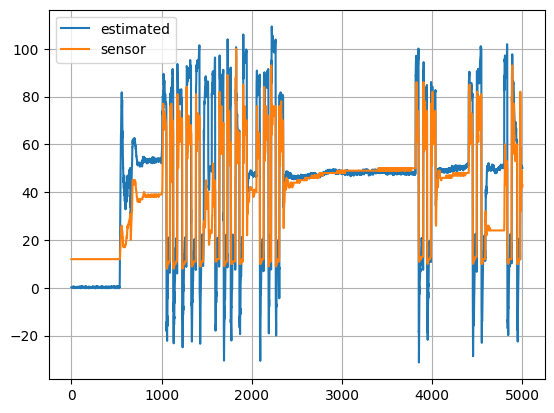

In [325]:
import matplotlib.pyplot as plt
plt.plot(-dataset[:,-1])
plt.plot(dataset_measured[:,0])
plt.legend(['estimated', 'sensor'])
plt.grid(True)

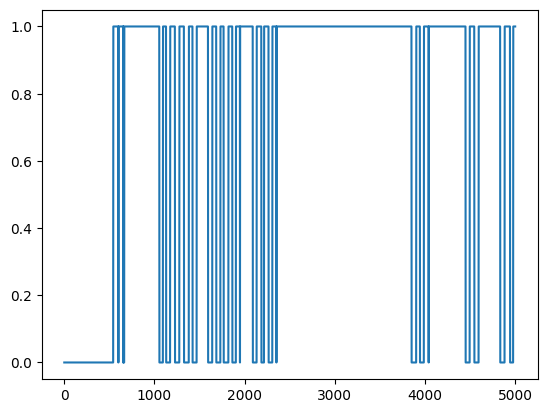

In [327]:
plt.plot(dataset_contact_states[:,0])